In [32]:
import torch
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(f"Using device: {device}")

Using device: cuda


In [33]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

CUDA available: True
Number of GPUs: 2
GPU Name: Tesla T4


/////////////////////////////////////////////////////////////

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Function to remove silence from an audio file
def remove_silence(audio_path, sr=22050, top_db=20):
    try:
        y, _ = librosa.load(audio_path, sr=sr)
        non_silent_intervals = librosa.effects.split(y, top_db=top_db)
        y_non_silent = np.concatenate([y[start:end] for start, end in non_silent_intervals])
        return y_non_silent
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Function to extract features from an audio file
def extract_features(y, sr=22050, n_mfcc=12, window_size=2048, hop_length=512):
    try:
        # Extract audio features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        zero_crossings = sum(librosa.zero_crossings(y))
        energy = sum(librosa.feature.rms(y=y)[0])
        pitches, _ = librosa.core.piptrack(y=y, sr=sr)
        pitch = np.mean(pitches)

        # Combine features into a single array
        features = np.hstack([
            mfcc.mean(axis=1), 
            delta_mfcc.mean(axis=1), 
            delta2_mfcc.mean(axis=1), 
            [zero_crossings], 
            [energy],
            [pitch]
        ])
        return features
    except Exception as e:
        print(f"Error processing audio data: {e}")
        return None

# Function to load data from a folder and save to CSV
def process_and_save_to_csv(folder_path, label, csv_path, has_subfolders=False, sr=22050, top_db=20):
    data = []
    labels = []

    if has_subfolders:
        for gender in ['female', 'male']:
            gender_folder = os.path.join(folder_path, gender)
            if not os.path.exists(gender_folder):
                continue

            for file_name in os.listdir(gender_folder):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(gender_folder, file_name)
                    y = remove_silence(file_path, sr=sr, top_db=top_db)
                    if y is not None:
                        features = extract_features(y, sr=sr)
                        if features is not None:
                            data.append(features)
                            labels.append(label)
    else:
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)
                y = remove_silence(file_path, sr=sr, top_db=top_db)
                if y is not None:
                    features = extract_features(y, sr=sr)
                    if features is not None:
                        data.append(features)
                        labels.append(label)

    # Save to CSV
    if data:
        df = pd.DataFrame(data)
        df['label'] = labels
        df.to_csv(csv_path, index=False)
        print(f"Saved data to {csv_path}")
    else:
        print(f"No valid data found in {folder_path} to save.")

# Paths to datasets and CSV files
train_asian_path = "/kaggle/input/dataset/Dataset/Train/Asian"
train_white_path = "/kaggle/input/dataset/Dataset/Train/White"
test_asian_path = "/kaggle/input/dataset/Dataset/test/Asian"
test_white_path = "/kaggle/input/dataset/Dataset/test/White"

train_asian_csv = "train_asian_features.csv"
train_white_csv = "train_white_features.csv"
test_asian_csv = "test_asian_features.csv"
test_white_csv = "test_white_features.csv"

# Process and save datasets
process_and_save_to_csv(train_asian_path, "Asian", train_asian_csv, has_subfolders=True)
process_and_save_to_csv(train_white_path, "White", train_white_csv, has_subfolders=True)
process_and_save_to_csv(test_asian_path, "Asian", test_asian_csv, has_subfolders=False)
process_and_save_to_csv(test_white_path, "White", test_white_csv, has_subfolders=False)

# Load CSV data for training and testing
def load_data_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    X = df.iloc[:, :-1].values  # All columns except 'label'
    y = df['label'].values  # The 'label' column
    return X, y

X_train_asian, y_train_asian = load_data_from_csv(train_asian_csv)
X_train_white, y_train_white = load_data_from_csv(train_white_csv)
X_test_asian, y_test_asian = load_data_from_csv(test_asian_csv)
X_test_white, y_test_white = load_data_from_csv(test_white_csv)

# Combine data and labels
X_train = np.vstack((X_train_asian, X_train_white))
y_train = np.hstack((y_train_asian, y_train_white))
X_test = np.vstack((X_test_asian, X_test_white))
y_test = np.hstack((y_test_asian, y_test_white))

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data processing and scaling complete.")


Saved data to train_asian_features.csv
Saved data to train_white_features.csv
Saved data to test_asian_features.csv
Saved data to test_white_features.csv
Data processing and scaling complete.


Best Parameters for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Score for SVM: 0.6666666666666666
Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score for Random Forest: 0.7777777777777777
Model: K-Nearest Neighbors (k=5)
Training Accuracy: 80.00%
Testing Accuracy: 82.50%
Precision: 0.8258
Recall: 0.8250
F1 Score: 0.8249

Classification Report:
              precision    recall  f1-score   support

       Asian       0.84      0.80      0.82        20
       White       0.81      0.85      0.83        20

    accuracy                           0.82        40
   macro avg       0.83      0.82      0.82        40
weighted avg       0.83      0.82      0.82        40



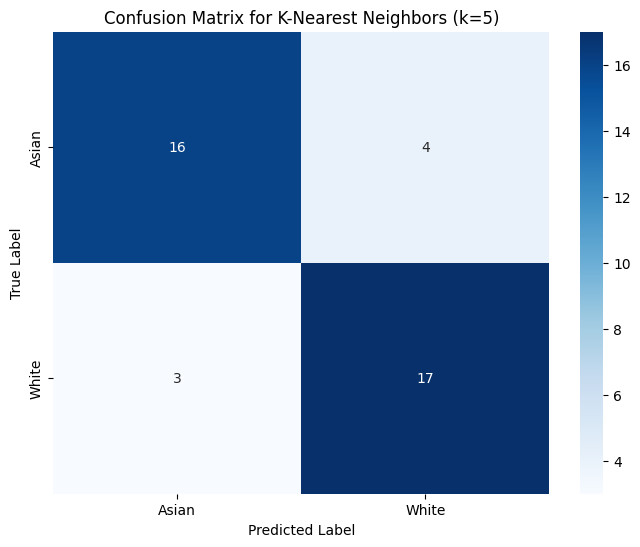

Model: Support Vector Machine (Tuned)
Training Accuracy: 93.33%
Testing Accuracy: 75.00%
Precision: 0.7500
Recall: 0.7500
F1 Score: 0.7500

Classification Report:
              precision    recall  f1-score   support

       Asian       0.75      0.75      0.75        20
       White       0.75      0.75      0.75        20

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40



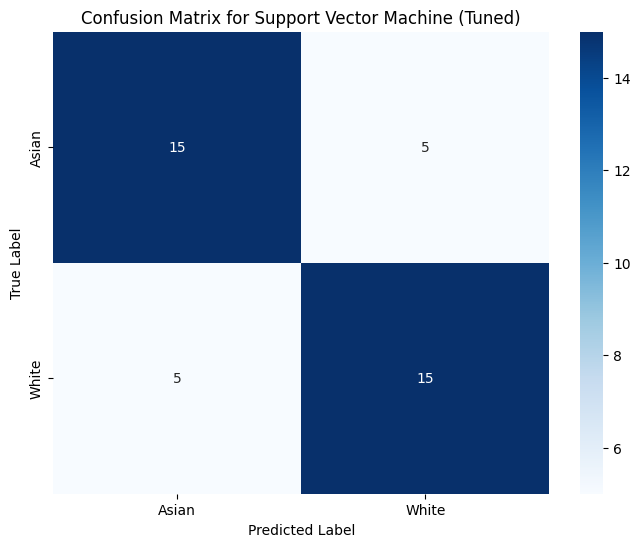

Model: Random Forest (Tuned)
Training Accuracy: 100.00%
Testing Accuracy: 52.50%
Precision: 0.7564
Recall: 0.5250
F1 Score: 0.3866

Classification Report:
              precision    recall  f1-score   support

       Asian       0.51      1.00      0.68        20
       White       1.00      0.05      0.10        20

    accuracy                           0.53        40
   macro avg       0.76      0.53      0.39        40
weighted avg       0.76      0.53      0.39        40



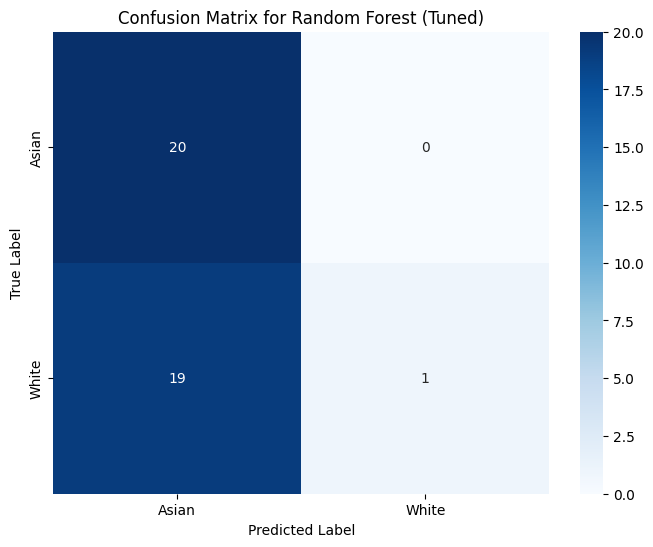

Model: Gaussian Mixture Model (Full Covariance)
Training Accuracy: 33.33%
Testing Accuracy: 50.00%
Precision: 0.7500
Recall: 0.5000
F1 Score: 0.3333

Classification Report:
              precision    recall  f1-score   support

       Asian       0.00      0.00      0.00        20
       White       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



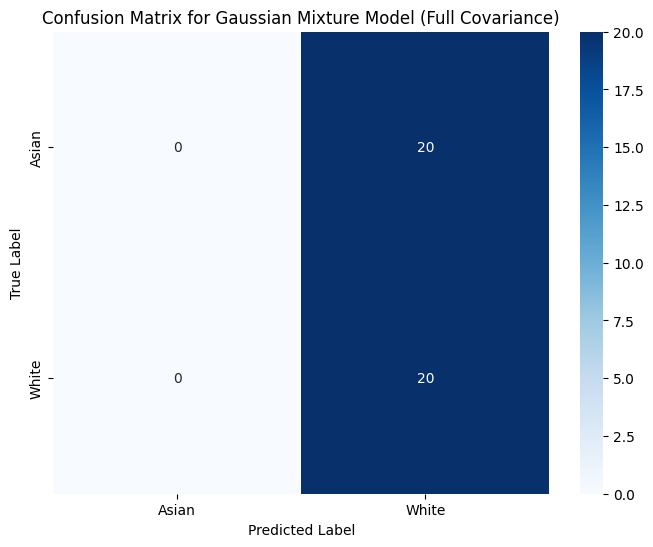

Model: Gaussian Naive Bayes
Training Accuracy: 64.44%
Testing Accuracy: 52.50%
Precision: 0.5251
Recall: 0.5250
F1 Score: 0.5247

Classification Report:
              precision    recall  f1-score   support

       Asian       0.52      0.55      0.54        20
       White       0.53      0.50      0.51        20

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.52        40



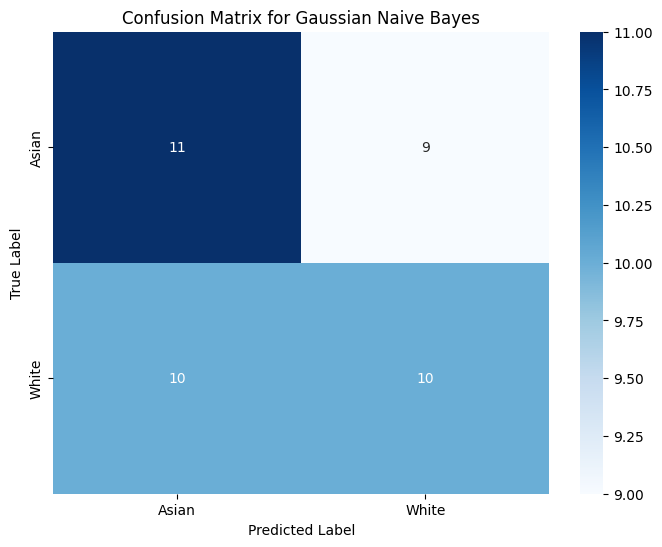

=== Summary of Results ===
                                      Model  Training Accuracy (%)  \
0                 K-Nearest Neighbors (k=5)              80.000000   
1            Support Vector Machine (Tuned)              93.333333   
2                     Random Forest (Tuned)             100.000000   
3  Gaussian Mixture Model (Full Covariance)              33.333333   
4                      Gaussian Naive Bayes              64.444444   

   Testing Accuracy (%)  Precision  Recall  F1 Score  
0                  82.5   0.825815   0.825  0.824891  
1                  75.0   0.750000   0.750  0.750000  
2                  52.5   0.756410   0.525  0.386602  
3                  50.0   0.750000   0.500  0.333333  
4                  52.5   0.525063   0.525  0.524703  


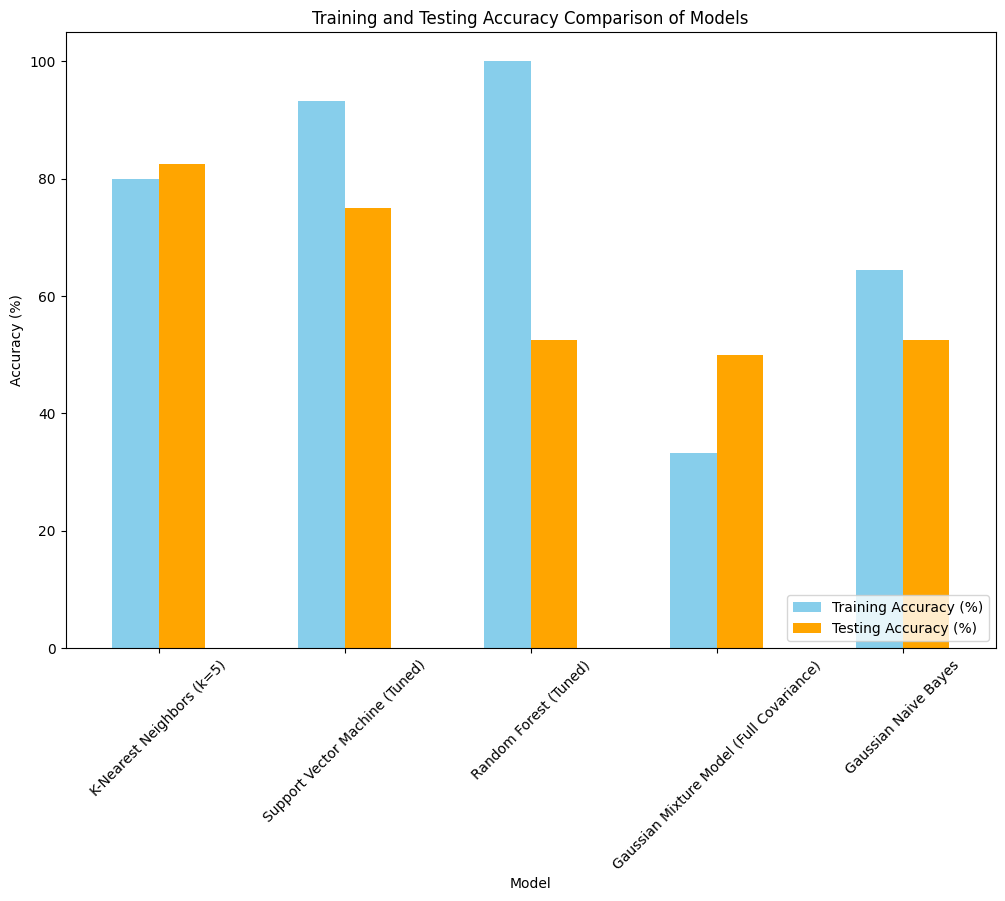

In [53]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress all warnings related to metrics
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics")

# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the SVM model with default settings
svm = SVC()

# Define the parameter grid for GridSearchCV for SVM
param_grid_svm = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

# Define the RandomForestClassifier with default settings
rf = RandomForestClassifier()

# Define the parameter grid for GridSearchCV for RandomForest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Define models and their parameters
models = [
    (KNeighborsClassifier(n_neighbors=5), "K-Nearest Neighbors (k=5)"),
    (SVC(kernel="linear", C=1.0), "Support Vector Machine (Linear Kernel)"),
    (RandomForestClassifier(random_state=42), "Random Forest (Tuned)"),  # Placeholder for tuned RF model
    (GaussianMixture(n_components=len(label_encoder.classes_), covariance_type="full", random_state=42), "Gaussian Mixture Model (Full Covariance)"),
    (GaussianNB(), "Gaussian Naive Bayes")
]


def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test_encoded, label_encoder):
    # Train the model
    if isinstance(model, GaussianMixture):
        model.fit(X_train)  # GMM expects only features
        y_train_pred_encoded = model.predict(X_train)
        y_test_pred_encoded = model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_train_pred_encoded = model.predict(X_train)
        y_test_pred_encoded = model.predict(X_test)

    # Calculate metrics using encoded labels
    train_accuracy = accuracy_score(y_train, y_train_pred_encoded) * 100  # Train accuracy in %
    test_accuracy = accuracy_score(y_test_encoded, y_test_pred_encoded) * 100  # Test accuracy in %
    precision = precision_score(y_test_encoded, y_test_pred_encoded, average='weighted', zero_division=1)
    recall = recall_score(y_test_encoded, y_test_pred_encoded, average='weighted', zero_division=1)
    f1 = f1_score(y_test_encoded, y_test_pred_encoded, average='weighted', zero_division=1)

    # Decode predictions back to original labels for human readability
    y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)
    y_test = label_encoder.inverse_transform(y_test_encoded)

    # Display results in a clear format
    print("="*40)
    print(f"Model: {model_name}")
    print("="*40)
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Testing Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    print("="*40)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred, labels=label_encoder.classes_)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return {
        "Model": model_name,
        "Training Accuracy (%)": train_accuracy,
        "Testing Accuracy (%)": test_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# GridSearchCV for SVM hyperparameter tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearch for SVM
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=cv)
grid_search_svm.fit(X_train_scaled, y_train_encoded)

# Output best parameters and best score for SVM
print(f"Best Parameters for SVM: {grid_search_svm.best_params_}")
print(f"Best Cross-Validation Score for SVM: {grid_search_svm.best_score_}")

# Best SVM model
best_svm_model = grid_search_svm.best_estimator_

# Add tuned SVM model to the models list
models[1] = (best_svm_model, "Support Vector Machine (Tuned)")

# GridSearchCV for Random Forest Hyperparameter Tuning
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=cv)
grid_search_rf.fit(X_train_scaled, y_train_encoded)

# Output best parameters and best score for Random Forest
print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best Cross-Validation Score for Random Forest: {grid_search_rf.best_score_}")

# Best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# Add tuned Random Forest model to the models list
models[2] = (best_rf_model, "Random Forest (Tuned)")

# Evaluate each model
results = []
for model, model_name in models:
    result = train_and_evaluate_model(
        model, model_name, X_train_scaled, y_train_encoded,
        X_test_scaled, y_test_encoded, label_encoder
    )
    results.append(result)

# Print summary of results
print("=== Summary of Results ===")
results_df = pd.DataFrame(results)
print(results_df)

# Plot overall performance comparison
results_df.set_index("Model", inplace=True)
results_df[['Training Accuracy (%)', 'Testing Accuracy (%)']].plot(kind='bar', figsize=(12, 8), color=['skyblue', 'orange'])
plt.title("Training and Testing Accuracy Comparison of Models")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


Detailed File Statistics:

                  Dataset                              File  Duration (s)  Sampling Rate (Hz)  Signal Length (Samples)  Frames (Seconds)
Training - Asian - Female    2484@17h50m18s(26_11_08)-2.wav       2888.51                8000                 23108080           2888.51
Training - Asian - Female    1121@01h18m19s(30_12_08)-2.wav        197.57                8000                  1580560            197.57
Training - Asian - Female    9000@13h43m30s(17_06_08)-2.wav       4866.67                8000                 38933360           4866.67
Training - Asian - Female    0258@20h57m48s(17_04_09)-2.wav       2214.27                8000                 17714160           2214.27
Training - Asian - Female    2484@16h36m29s(29_11_08)-2.wav       2238.37                8000                 17906960           2238.37
Training - Asian - Female    2484@16h36m29s(29_11_08)-1.wav       2238.36                8000                 17906880           2238.36
Training - Asi

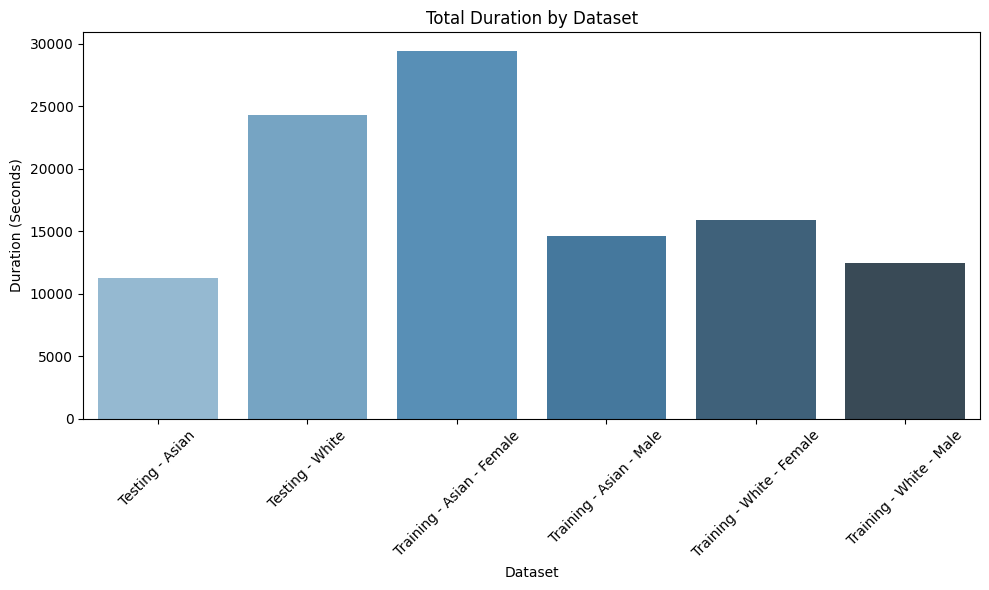

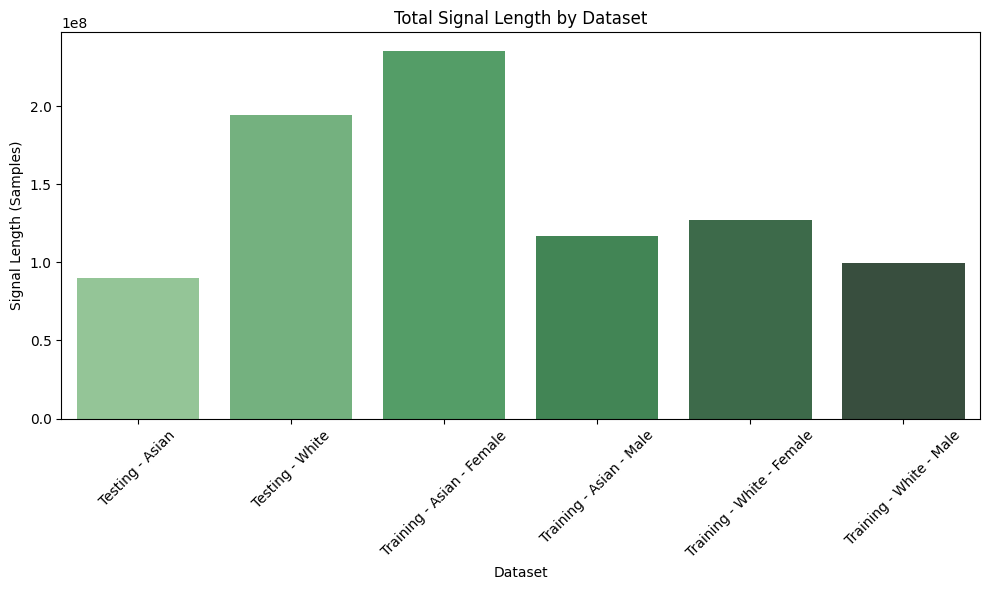

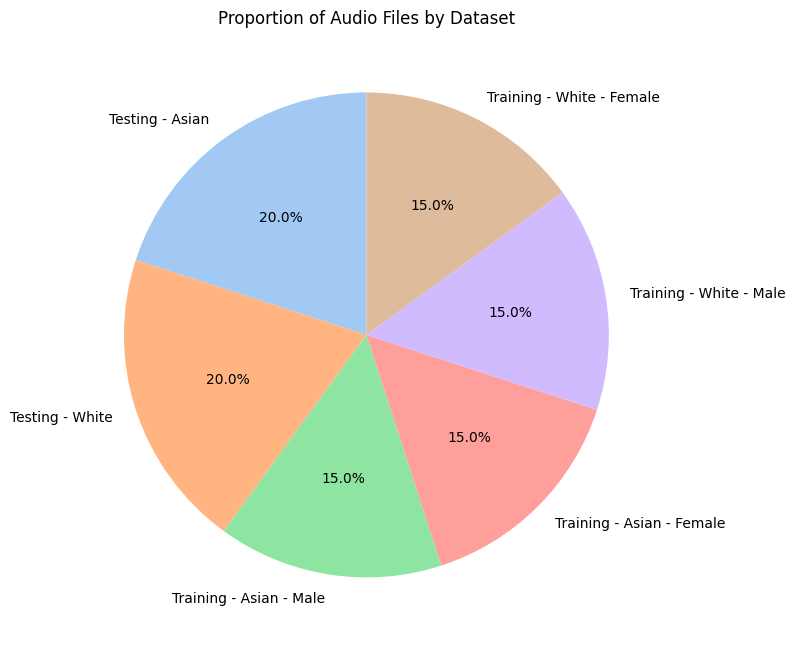

In [4]:
import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract audio statistics (with specific handling for "small female" and "Femal")
def get_audio_statistics(folder_path, label, has_subfolders=False):
    stats = []
    if has_subfolders:
        # Check for 'female' and 'male' subfolders, handling different naming conventions
        for gender in ['female', 'male']:
            # Handling 'small female' in Asian and 'Femal' in White by checking folder names directly
            if gender == 'female':
                # Check for 'small female' in 'Asian' and 'Femal' in 'White'
                gender_folder_asian = os.path.join(folder_path, 'female')  # Specific to Asian
                gender_folder_white = os.path.join(folder_path, 'Female')  # Specific to White
                gender_folder = gender_folder_asian if "Asian" in folder_path else gender_folder_white
                
            else:
                gender_folder = os.path.join(folder_path, gender)

            if not os.path.exists(gender_folder):
                continue
            for file_name in os.listdir(gender_folder):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(gender_folder, file_name)
                    y, sr = librosa.load(file_path, sr=None)
                    duration = len(y) / sr
                    stats.append({
                        "Dataset": f"{label} - {gender.capitalize()}",
                        "File": file_name,
                        "Duration (s)": round(duration, 2),
                        "Sampling Rate (Hz)": sr,
                        "Signal Length (Samples)": len(y),
                        "Frames (Seconds)": round(len(y) / sr, 2)
                    })
    else:
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)
                y, sr = librosa.load(file_path, sr=None)
                duration = len(y) / sr
                stats.append({
                    "Dataset": label,
                    "File": file_name,
                    "Duration (s)": round(duration, 2),
                    "Sampling Rate (Hz)": sr,
                    "Signal Length (Samples)": len(y),
                    "Frames (Seconds)": round(len(y) / sr, 2)
                })
    return stats

# Paths to datasets
train_asian_path = "/kaggle/input/dataset/Dataset/Train/Asian"
train_white_path = "/kaggle/input/dataset/Dataset/Train/White"
test_asian_path = "/kaggle/input/dataset/Dataset/test/Asian"
test_white_path = "/kaggle/input/dataset/Dataset/test/White"

# Collect statistics for each dataset, including the white female subfolder
train_asian_stats = get_audio_statistics(train_asian_path, "Training - Asian", has_subfolders=True)
train_white_stats = get_audio_statistics(train_white_path, "Training - White", has_subfolders=True)
test_asian_stats = get_audio_statistics(test_asian_path, "Testing - Asian", has_subfolders=False)
test_white_stats = get_audio_statistics(test_white_path, "Testing - White", has_subfolders=False)

# Combine statistics
all_stats = train_asian_stats + train_white_stats + test_asian_stats + test_white_stats

# Convert to DataFrame for display
stats_df = pd.DataFrame(all_stats)

# Summarize statistics for each dataset
summary_df = stats_df.groupby("Dataset").agg({
    "Duration (s)": "sum",
    "Sampling Rate (Hz)": "first",
    "Signal Length (Samples)": "sum",
    "Frames (Seconds)": "sum"
}).reset_index()

# Print the detailed and summary tables
print("Detailed File Statistics:\n")
print(stats_df.to_string(index=False))
print("\nSummary Statistics:\n")
print(summary_df.to_string(index=False))

# -------------------
# Visualization
# -------------------

# Plot 1: Bar plot of total duration by dataset
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="Dataset", y="Duration (s)", palette="Blues_d")
plt.title("Total Duration by Dataset")
plt.ylabel("Duration (Seconds)")
plt.xlabel("Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Bar plot of total signal length by dataset
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="Dataset", y="Signal Length (Samples)", palette="Greens_d")
plt.title("Total Signal Length by Dataset")
plt.ylabel("Signal Length (Samples)")
plt.xlabel("Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Pie chart for dataset distribution
dataset_counts = stats_df['Dataset'].value_counts()
plt.figure(figsize=(8, 8))
dataset_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette("pastel"), startangle=90)
plt.title("Proportion of Audio Files by Dataset")
plt.ylabel("")  # Remove y-label
plt.tight_layout()
plt.show()
